# CUSUM-Based Structural Break Detection Analysis
This notebook explores the use of CUSUM (Cumulative Sum) and CUSUMSQ statistics for detecting structural breaks in time series data. We investigate different lag selection strategies based on Partial Autocorrelation Function (PACF) analysis and evaluate their performance using machine learning models.
## Table of Contents
1. [Setup and Data Loading](#setup)
2. [PACF Analysis and Visualization](#pacf-analysis)
3. [CUSUM Methodology](#cusum-methodology)
4. [Lag Selection Strategies](#lag-selection)
5. [Model Evaluation](#model-evaluation)
6. [Hyperparameter Tuning](#hyperparameter-tuning)
7. [Results Summary](#results-summary)

## 1. Setup and Data Loading {#setup}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from typing import Dict, List, Tuple
from tqdm import tqdm

# Statistical analysis
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

# Machine learning
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier

# Custom modules
from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData
from src.utils.training_class import TimeSeriesModelTrainer

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📦 All packages imported successfully!")

📦 All packages imported successfully!


In [2]:
# Load the data
print("📊 Loading structural break data...")
data_loader = StructuralBreakDataLoader()
X_train, y_train, X_test = data_loader.load_data(use_crunch=False)

# Get all time series
train_series = data_loader.get_all_train_series()
test_series = data_loader.get_all_test_series()

# Display basic statistics
stats = data_loader.get_statistics()
print(f"\n✅ Data loaded successfully!")
print(f"📈 Training series: {len(train_series):,}")
print(f"🧪 Test series: {len(test_series):,}")
print(f"✅ Positive examples (breaks): {stats['n_positive']:,} ({stats['positive_ratio']:.1%})")
print(f"❌ Negative examples (no breaks): {stats['n_negative']:,}")
print(f"📏 Series length range: {stats['min_length']} - {stats['max_length']} (mean: {stats['mean_length']:.1f})")

📊 Loading structural break data...


INFO:src.data.dataLoader:Data loaded successfully from local files



✅ Data loaded successfully!
📈 Training series: 10,001
🧪 Test series: 101
✅ Positive examples (breaks): 2,909 (29.1%)
❌ Negative examples (no breaks): 7,092
📏 Series length range: 1258 - 3478 (mean: 2371.3)


## 2. PACF Analysis and Visualization {#pacf-analysis}
We start by exploring the Partial Autocorrelation Function (PACF) to understand the autocorrelation structure in our time series. This will help us determine appropriate lag selection strategies.

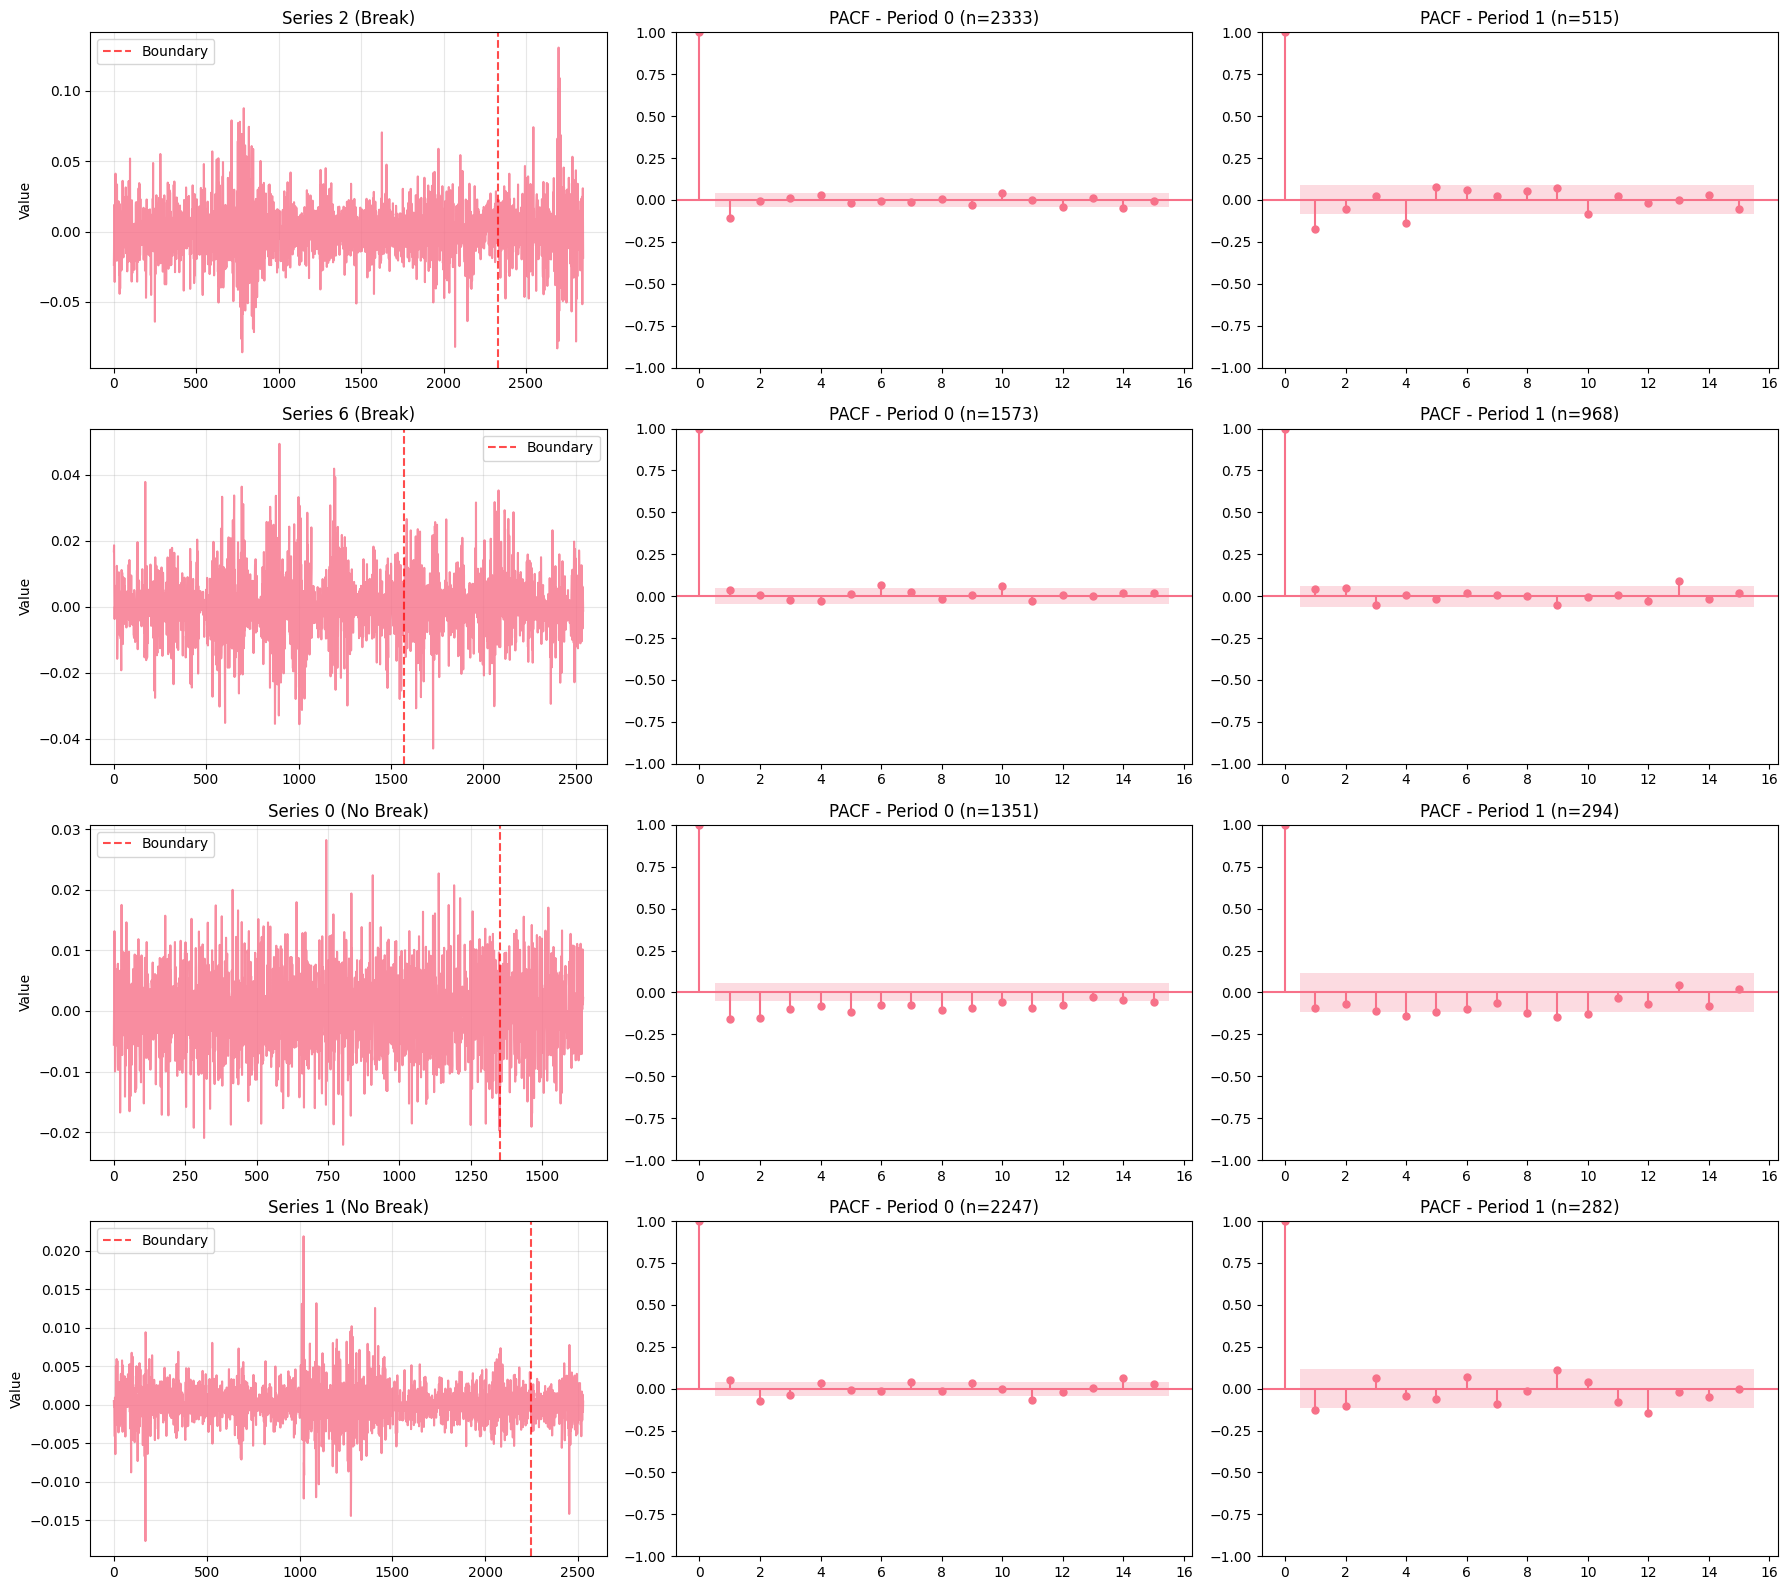

In [3]:
def plot_example_series_and_pacf(series_dict: Dict[int, TimeSeriesData], n_examples: int = 4):
    """Plot example time series and their PACF analysis."""

    # Select examples with and without breaks
    positive_ids = [sid for sid, ts in series_dict.items() if ts.has_break]
    negative_ids = [sid for sid, ts in series_dict.items() if not ts.has_break]

    selected_ids = positive_ids[:n_examples // 2] + negative_ids[:n_examples // 2]

    fig, axes = plt.subplots(n_examples, 3, figsize=(18, 4 * n_examples))

    for i, sid in enumerate(selected_ids):
        ts = series_dict[sid]

        # Plot time series
        axes[i, 0].plot(ts.values, linewidth=1.5, alpha=0.8)
        axes[i, 0].axvline(x=ts.boundary_point, color='red', linestyle='--', alpha=0.7, label='Boundary')
        axes[i, 0].set_title(f'Series {sid} {"(Break)" if ts.has_break else "(No Break)"}')
        axes[i, 0].set_ylabel('Value')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        # Plot PACF for period 0
        plot_pacf(ts.period_0_values, ax=axes[i, 1], lags=min(15, len(ts.period_0_values) // 2 - 1))
        axes[i, 1].set_title(f'PACF - Period 0 (n={len(ts.period_0_values)})')

        # Plot PACF for period 1
        plot_pacf(ts.period_1_values, ax=axes[i, 2], lags=min(15, len(ts.period_1_values) // 2 - 1))
        axes[i, 2].set_title(f'PACF - Period 1 (n={len(ts.period_1_values)})')

    plt.tight_layout()
    plt.show()


# Plot examples
plot_example_series_and_pacf(train_series, n_examples=4)

🔍 Analyzing PACF significance across all series...


Analyzing PACF: 100%|██████████| 10001/10001 [00:08<00:00, 1228.63it/s]


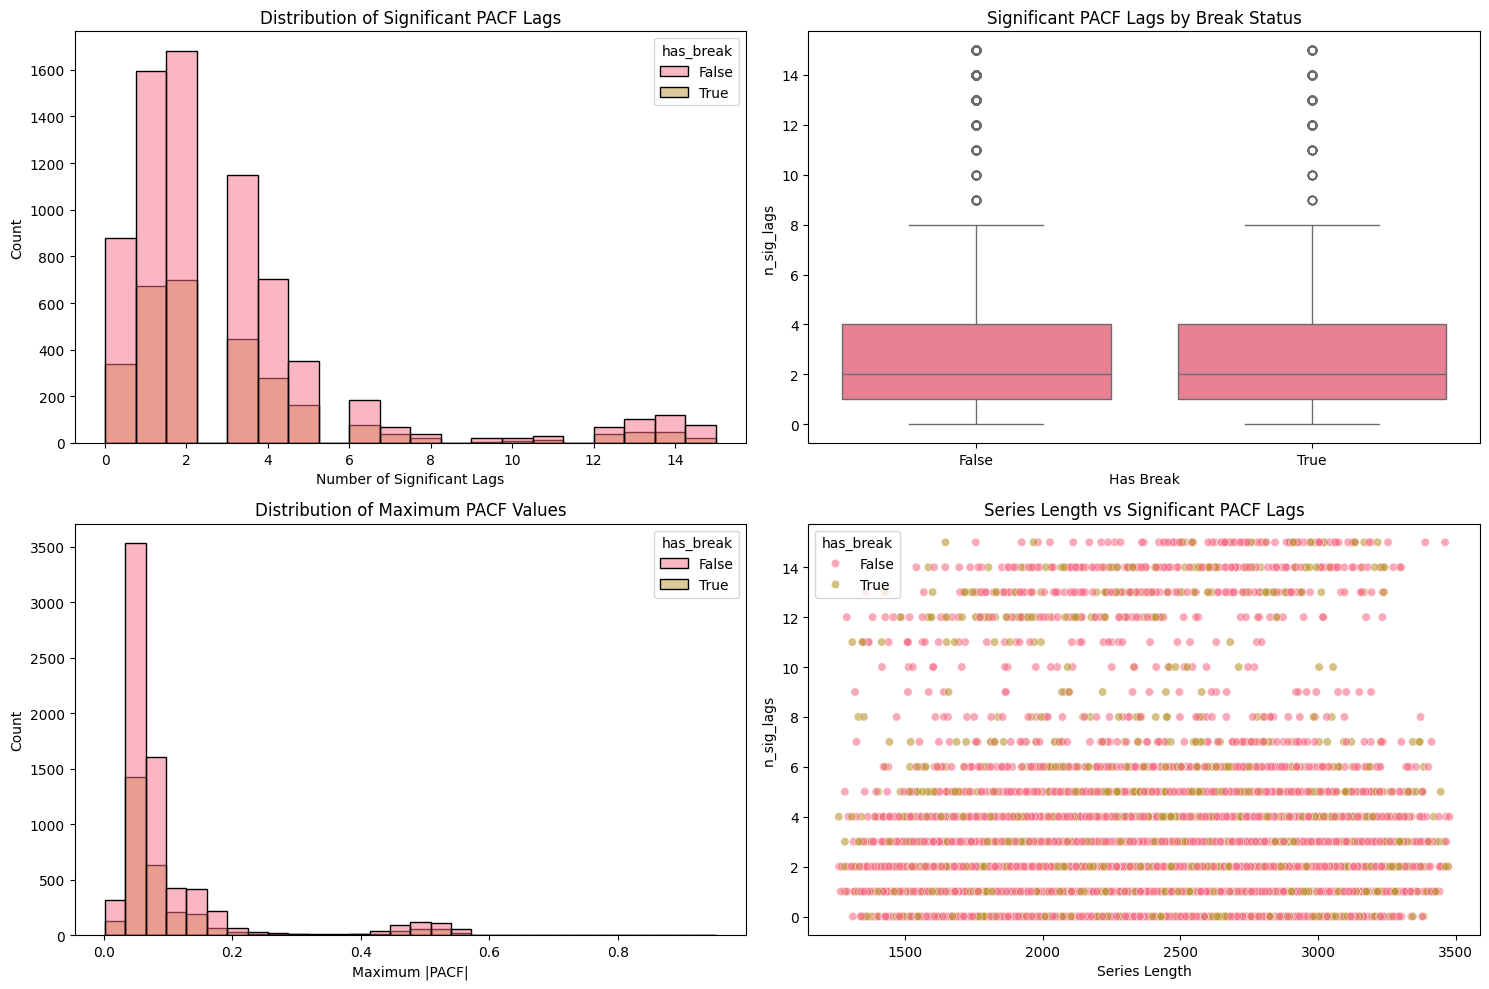


📊 PACF Analysis Summary:
Mean significant lags (with breaks): 2.93
Mean significant lags (no breaks): 2.91


In [4]:
def analyze_pacf_significance(series_dict: Dict[int, TimeSeriesData], max_lag: int = 15, alpha: float = 0.05):
    """Analyze PACF significance across all series."""

    results = []

    for sid, ts in tqdm(series_dict.items(), desc="Analyzing PACF"):
        full_series = np.concatenate([ts.period_0_values, ts.period_1_values])

        try:
            vals, conf = pacf(full_series, nlags=max_lag, alpha=alpha)

            # Count significant lags
            sig_lags = []
            for lag in range(1, len(vals)):
                lo, hi = conf[lag]
                if hi < 0 or lo > 0:
                    sig_lags.append(lag)

            results.append({
                'series_id': sid,
                'has_break': ts.has_break,
                'series_length': len(full_series),
                'n_sig_lags': len(sig_lags),
                'sig_lags': sig_lags,
                'max_pacf': np.max(np.abs(vals[1:])) if len(vals) > 1 else 0
            })

        except Exception as e:
            print(f"Warning: PACF analysis failed for series {sid}: {e}")
            continue

    return pd.DataFrame(results)


# Analyze PACF significance
print("🔍 Analyzing PACF significance across all series...")
pacf_analysis = analyze_pacf_significance(train_series)

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of significant lags
sns.histplot(data=pacf_analysis, x='n_sig_lags', hue='has_break', bins=20, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Significant PACF Lags')
axes[0, 0].set_xlabel('Number of Significant Lags')

# Box plot of significant lags by break status
sns.boxplot(data=pacf_analysis, x='has_break', y='n_sig_lags', ax=axes[0, 1])
axes[0, 1].set_title('Significant PACF Lags by Break Status')
axes[0, 1].set_xlabel('Has Break')

# Max PACF value distribution
sns.histplot(data=pacf_analysis, x='max_pacf', hue='has_break', bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Maximum PACF Values')
axes[1, 0].set_xlabel('Maximum |PACF|')

# Relationship between series length and significant lags
sns.scatterplot(data=pacf_analysis, x='series_length', y='n_sig_lags',
                hue='has_break', alpha=0.6, ax=axes[1, 1])
axes[1, 1].set_title('Series Length vs Significant PACF Lags')
axes[1, 1].set_xlabel('Series Length')

plt.tight_layout()
plt.show()

print(f"\n📊 PACF Analysis Summary:")
print(f"Mean significant lags (with breaks): {pacf_analysis[pacf_analysis['has_break']]['n_sig_lags'].mean():.2f}")
print(f"Mean significant lags (no breaks): {pacf_analysis[~pacf_analysis['has_break']]['n_sig_lags'].mean():.2f}")

## 3. CUSUM Methodology {#cusum-methodology}
CUSUM (Cumulative Sum) tests are designed to detect changes in the mean of a time series. We implement both CUSUM and CUSUMSQ (cumulative sum of squares) statistics based on regression residuals.

In [5]:
def _build_lagged_matrix(series: np.ndarray, lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """Build lagged design matrix X and vector y."""
    N = len(series)
    if N <= lags:
        return None, None

    y = series[lags:]
    X = np.ones((N - lags, lags + 1), dtype=float)

    for j in range(1, lags + 1):
        X[:, j] = series[lags - j: N - j]

    return X, y


def _ols_fit(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
    """Fit OLS: returns beta, residuals, rss."""
    XT_X = X.T.dot(X)
    try:
        beta = np.linalg.solve(XT_X, X.T.dot(y))
    except np.linalg.LinAlgError:
        beta = np.linalg.pinv(XT_X).dot(X.T.dot(y))

    resid = y - X.dot(beta)
    rss = float(resid.dot(resid))

    return beta, resid, rss


def compute_cusum_statistics(ts_obj: TimeSeriesData, lags: int) -> Dict[str, float]:
    """
    Compute CUSUM and CUSUMSQ statistics for structural break detection.

    Parameters:
    -----------
    ts_obj : TimeSeriesData
        Time series object containing the data
    lags : int
        Number of lags to use in the autoregressive model

    Returns:
    --------
    dict : Dictionary containing CUSUM statistics
    """
    series_full = ts_obj.values

    # Build lagged matrices
    X_full, y_full = _build_lagged_matrix(series_full, lags=lags)

    if X_full is None or y_full is None:
        return {k: np.nan for k in ["T_cumsum", "p_cumsum", "cusumsq_stat", "cusumsq_pvalue"]}

    # Sample sizes
    n_full = len(y_full)
    m = lags + 1

    # Fit full OLS
    beta_full, resid_full, rss_full = _ols_fit(X_full, y_full)

    df_resid = n_full - m
    sigma_hat = np.sqrt(rss_full / df_resid)

    # Effective break index in residuals
    K = len(ts_obj.period_0_values)
    k_eff = K - lags
    u = k_eff / n_full

    # CUSUM statistic
    resid_pre = resid_full[:k_eff]
    S = float(np.sum(resid_pre))

    denom = sigma_hat * np.sqrt(n_full * u * (1 - u))
    T_cusum = S / denom
    p_cusum = 2 * (1 - st.norm.cdf(abs(T_cusum)))

    # CUSUMSQ statistic
    sumsq_pre = float(np.sum(resid_pre ** 2))
    C = sumsq_pre / rss_full
    var_C = 2 * u * (1 - u) / (n_full + 2)

    Z_cusumsq = (C - u) / np.sqrt(var_C)
    p_cusumsq = 2 * (1 - st.norm.cdf(abs(Z_cusumsq)))

    return {
        "T_cumsum": T_cusum,
        "p_cumsum": p_cusum,
        "cusumsq_stat": Z_cusumsq,
        "cusumsq_pvalue": p_cusumsq
    }


# Test the CUSUM computation on a few examples
print("🧮 Testing CUSUM computation on example series...")
example_results = []
for sid in list(train_series.keys())[:5]:
    ts = train_series[sid]
    cusum_stats = compute_cusum_statistics(ts, lags=5)
    cusum_stats['series_id'] = sid
    cusum_stats['has_break'] = ts.has_break
    example_results.append(cusum_stats)

example_df = pd.DataFrame(example_results)
print(example_df)

🧮 Testing CUSUM computation on example series...
   T_cumsum  p_cumsum  cusumsq_stat  cusumsq_pvalue  series_id  has_break
0 -0.071118  0.943304      0.232829        0.815894          0      False
1  1.468585  0.141945      3.854599        0.000116          1      False
2 -1.761165  0.078210     -9.313774        0.000000          2       True
3  0.195576  0.844942     -3.458015        0.000544          3      False
4 -0.159373  0.873375     -0.297818        0.765842          4      False


## 4. Lag Selection Strategies {#lag-selection}
We explore different strategies for selecting the number of lags in our autoregressive model:
1. **Fixed lag approach**: Using a constant number of lags
2. **PACF-based approach**: Using the number of significant PACF lags
3. **Specific significant lags**: Using only the exact lags that are significant

🔧 Testing Strategy 1: Fixed Lag Approach


Testing fixed lags: 100%|██████████| 15/15 [00:32<00:00,  2.18s/it]



🏆 Best fixed lag: 5 with AUC: 0.5801

🔧 Testing Strategy 2: PACF-Based Lag Count


PACF-based features: 100%|██████████| 10001/10001 [00:09<00:00, 1053.69it/s]


🏆 PACF-based lag selection AUC: 0.5871


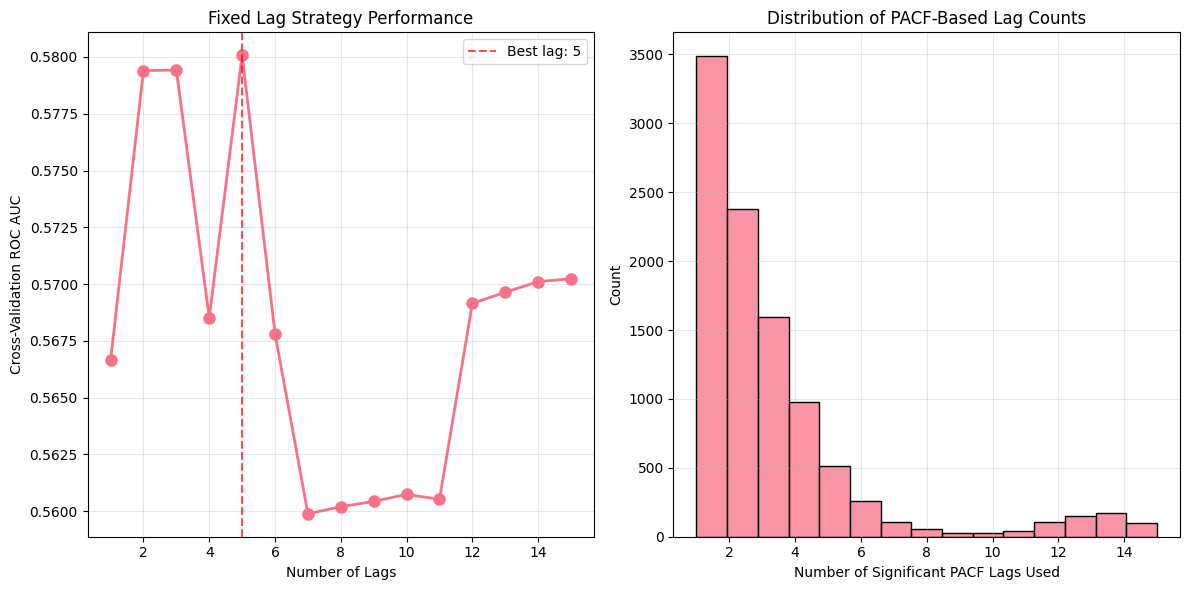

In [6]:
def get_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05) -> List[int]:
    """Get list of lags with significant PACF values."""
    try:
        vals, conf = pacf(series, nlags=max_lag, alpha=alpha)
        sig_lags = [
            lag for lag in range(1, len(vals))
            if (conf[lag][1] < 0) or (conf[lag][0] > 0)
        ]
        return sig_lags
    except:
        return []


def count_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05) -> int:
    """Count number of significant PACF lags."""
    sig_lags = get_sig_pacf_lags(series, max_lag, alpha)
    return len(sig_lags) if sig_lags else 1  # Return at least 1


# Strategy 1: Fixed lag approach
print("🔧 Testing Strategy 1: Fixed Lag Approach")
print("=" * 50)

best_score = -np.inf
best_lag = None
scores_per_lag = {}

for lag in tqdm(range(1, 16), desc="Testing fixed lags"):
    feature_list = []
    labels = []
    series_ids = []

    for series_id, ts_obj in train_series.items():
        feats = compute_cusum_statistics(ts_obj, lags=lag)
        if not any(np.isnan(list(feats.values()))):  # Skip if any NaN
            feature_list.append(feats)
            series_ids.append(series_id)
            labels.append(ts_obj.has_break)

    if len(feature_list) < 10:  # Skip if too few valid samples
        continue

    feature_df = pd.DataFrame(feature_list, index=series_ids)
    label_series = pd.Series(labels, index=series_ids, name='has_break')

    # Cross-validate with Logistic Regression
    model = LogisticRegressionCV(max_iter=1000)
    cv_result = cross_validate(model, feature_df, label_series, cv=5, scoring='roc_auc', n_jobs=-1)
    mean_score = cv_result["test_score"].mean()

    scores_per_lag[lag] = mean_score
    if mean_score > best_score:
        best_score = mean_score
        best_lag = lag

# Plot results
plt.figure(figsize=(12, 6))
lags = list(scores_per_lag.keys())
scores = list(scores_per_lag.values())

plt.subplot(1, 2, 1)
plt.plot(lags, scores, 'o-', linewidth=2, markersize=8)
plt.axvline(x=best_lag, color='red', linestyle='--', alpha=0.7, label=f'Best lag: {best_lag}')
plt.xlabel('Number of Lags')
plt.ylabel('Cross-Validation ROC AUC')
plt.title('Fixed Lag Strategy Performance')
plt.grid(True, alpha=0.3)
plt.legend()

print(f"\n🏆 Best fixed lag: {best_lag} with AUC: {best_score:.4f}")

# Strategy 2: PACF-based lag count
print(f"\n🔧 Testing Strategy 2: PACF-Based Lag Count")
print("=" * 50)

feature_list = []
labels = []
series_ids = []

for series_id, ts_obj in tqdm(train_series.items(), desc="PACF-based features"):
    series_full = ts_obj.values
    optimal_lags = count_sig_pacf_lags(series_full, max_lag=15, alpha=0.05)

    feats = compute_cusum_statistics(ts_obj, lags=optimal_lags)
    feats['n_sig_pacf_lags'] = optimal_lags

    if not any(np.isnan([v for k, v in feats.items() if k != 'n_sig_pacf_lags'])):
        feature_list.append(feats)
        series_ids.append(series_id)
        labels.append(ts_obj.has_break)

feature_df_pacf = pd.DataFrame(feature_list, index=series_ids)
label_series = pd.Series(labels, index=series_ids, name='has_break')

# Evaluate with Logistic Regression
model = LogisticRegressionCV(max_iter=1000)
cv_result = cross_validate(model, feature_df_pacf, label_series, cv=5, scoring='roc_auc', n_jobs=-1)
pacf_score = cv_result["test_score"].mean()

print(f"🏆 PACF-based lag selection AUC: {pacf_score:.4f}")

# Plot feature distributions
plt.subplot(1, 2, 2)
sns.histplot(data=feature_df_pacf, x='n_sig_pacf_lags', bins=15)
plt.xlabel('Number of Significant PACF Lags Used')
plt.ylabel('Count')
plt.title('Distribution of PACF-Based Lag Counts')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Evaluation {#model-evaluation}
Now we'll use our custom training class to evaluate different feature extraction approaches more systematically.

In [7]:
def cusum_feature_extractor_fixed_lag(ts_data: TimeSeriesData, lags: int = None) -> pd.DataFrame:
    """Feature extractor using fixed lag approach."""
    if lags is None:
        # Use best_lag if available, otherwise default to 5
        lags = best_lag if 'best_lag' in globals() and best_lag is not None else 5
    
    features = compute_cusum_statistics(ts_data, lags=lags)
    # Add numeric metadata only
    features['lags_used'] = float(lags)  # Ensure numeric
    
    return pd.DataFrame([features])

def cusum_feature_extractor_pacf_count(ts_data: TimeSeriesData) -> pd.DataFrame:
    """Feature extractor using PACF-based lag count."""
    series_full = ts_data.values
    optimal_lags = count_sig_pacf_lags(series_full, max_lag=15, alpha=0.05)
    
    features = compute_cusum_statistics(ts_data, lags=optimal_lags)
    # Add numeric metadata only
    features['lags_used'] = float(optimal_lags)  # Ensure numeric
    
    return pd.DataFrame([features])

def cusum_feature_extractor_pacf_specific(ts_data: TimeSeriesData) -> pd.DataFrame:
    """Feature extractor using specific significant PACF lags."""
    series_full = ts_data.values
    sig_lags = get_sig_pacf_lags(series_full, max_lag=15, alpha=0.05)
    
    if not sig_lags:
        sig_lags = [1]  # Default to lag 1 if no significant lags
    
    # Use only the specific significant lags
    features = compute_cusum_with_specific_lags(ts_data, sig_lags)
    # Add numeric metadata only
    features['n_lags_used'] = float(len(sig_lags))  # Ensure numeric
    features['max_lag_used'] = float(max(sig_lags))  # Additional numeric feature
    
    return pd.DataFrame([features])

def compute_cusum_with_specific_lags(ts_obj: TimeSeriesData, lags: List[int]) -> Dict[str, float]:
    """Compute CUSUM using only specific lag values."""
    series_full = ts_obj.values
    K = len(ts_obj.period_0_values)
    N = len(series_full)
    
    if not lags or N <= max(lags):
        return {k: np.nan for k in ["T_cumsum", "p_cumsum", "cusumsq_stat", "cusumsq_pvalue"]}
    
    max_lag = max(lags)
    
    # Build y and design matrix X (intercept + each specified lag)
    y = series_full[max_lag:]
    X = np.ones((len(y), len(lags) + 1))
    for i, lag in enumerate(lags, start=1):
        X[:, i] = series_full[max_lag - lag : N - lag]
    
    # OLS fit
    try:
        XT_X = X.T @ X
        beta = np.linalg.solve(XT_X, X.T @ y)
        resid = y - X @ beta
        rss = float(resid @ resid)
    except:
        return {k: np.nan for k in ["T_cumsum", "p_cumsum", "cusumsq_stat", "cusumsq_pvalue"]}
    
    # CUSUM calculations
    df_resid = len(y) - len(beta)
    sigma_hat = np.sqrt(rss / df_resid)
    k_eff = K - max_lag
    u = k_eff / len(y)
    resid_pre = resid[:k_eff]
    
    S = resid_pre.sum()
    denom = sigma_hat * np.sqrt(len(y) * u * (1 - u))
    T_cusum = S / denom
    p_cusum = 2 * (1 - st.norm.cdf(abs(T_cusum)))
    
    # CUSUMSQ
    sumsq_pre = (resid_pre**2).sum()
    C = sumsq_pre / rss
    var_C = 2 * u * (1 - u) / (len(y) + 2)
    Z_cusumsq = (C - u) / np.sqrt(var_C)
    p_cusumsq = 2 * (1 - st.norm.cdf(abs(Z_cusumsq)))
    
    return {
        "T_cumsum": T_cusum,
        "p_cumsum": p_cusum,
        "cusumsq_stat": Z_cusumsq,
        "cusumsq_pvalue": p_cusumsq
    }

# Evaluate all three approaches using our training class
print("🚀 Evaluating CUSUM approaches using TimeSeriesModelTrainer")
print("=" * 60)

approaches = [
    ("Fixed Lag", cusum_feature_extractor_fixed_lag),
    ("PACF Count", cusum_feature_extractor_pacf_count),
    ("PACF Specific", cusum_feature_extractor_pacf_specific)
]

evaluation_results = {}

for approach_name, feature_func in approaches:
    print(f"\n📊 Evaluating: {approach_name}")
    print("-" * 40)
    
    trainer = TimeSeriesModelTrainer(
        feature_extraction_func=feature_func,
        model_params={
            'n_estimators': 100,
            'max_depth': 4,
            'learning_rate': 0.1,
            'random_state': 42,
            'eval_metric': 'logloss'
        },
        cv_folds=5,
        random_state=42
    )
    
    try:
        results = trainer.train_and_evaluate()
        
        # Verify data types
        print(f"   Feature dtypes: {trainer.feature_df.dtypes.unique()}")
        print(f"   Features shape: {trainer.feature_df.shape}")
        print(f"   Missing values: {trainer.feature_df.isnull().sum().sum()}")
        
        evaluation_results[approach_name] = {
            'trainer': trainer,
            'results': results,
            'cv_auc_mean': results['cv_val_mean'],
            'cv_auc_std': results['cv_val_std']
        }
        
        print(f"✅ {approach_name} - CV AUC: {results['cv_val_mean']:.4f} ± {results['cv_val_std']:.4f}")
        
    except Exception as e:
        print(f"❌ {approach_name} failed: {e}")
        print(f"   Error type: {type(e).__name__}")
        
        # Try to extract features manually to debug
        try:
            print("   🔍 Debugging feature extraction...")
            sample_ts = list(train_series.values())[0]
            sample_features = feature_func(sample_ts)
            print(f"   Sample features shape: {sample_features.shape}")
            print(f"   Sample features dtypes:\n{sample_features.dtypes}")
            print(f"   Sample features columns: {list(sample_features.columns)}")
            print(f"   Sample features:\n{sample_features.head()}")
        except Exception as debug_e:
            print(f"   🚨 Feature extraction debug failed: {debug_e}")
        
        evaluation_results[approach_name] = None

# Compare results
print(f"\n🏆 CUSUM Approach Comparison")
print("=" * 50)
comparison_data = []
for approach, data in evaluation_results.items():
    if data is not None:
        comparison_data.append({
            'Approach': approach,
            'CV AUC Mean': data['cv_auc_mean'],
            'CV AUC Std': data['cv_auc_std'],
            'Features': data['results']['feature_count']
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format='%.4f'))

INFO:src.utils.training_class:Loading data automatically using StructuralBreakDataLoader...


🚀 Evaluating CUSUM approaches using TimeSeriesModelTrainer

📊 Evaluating: Fixed Lag
----------------------------------------


INFO:src.data.dataLoader:Data loaded successfully from local files
INFO:src.utils.training_class:Loaded 10001 training time series automatically
INFO:src.utils.training_class:Extracting features from 10001 time series...
Extracting features: 100%|██████████| 10001/10001 [00:02<00:00, 3976.55it/s]
INFO:src.utils.training_class:Successfully extracted 5 features from 10001 series
INFO:src.utils.training_class:Dataset shape: (10001, 5)
INFO:src.utils.training_class:Class distribution: {False: 7092, True: 2909}
INFO:src.utils.training_class:Performing 5-fold cross-validation...
INFO:src.utils.training_class:Training final model on full dataset...
INFO:src.utils.training_class:Training completed successfully!
INFO:src.utils.training_class:Loading data automatically using StructuralBreakDataLoader...


   Feature dtypes: [dtype('float64')]
   Features shape: (10001, 5)
   Missing values: 0
✅ Fixed Lag - CV AUC: 0.6087 ± 0.0148

📊 Evaluating: PACF Count
----------------------------------------


INFO:src.data.dataLoader:Data loaded successfully from local files
INFO:src.utils.training_class:Loaded 10001 training time series automatically
INFO:src.utils.training_class:Extracting features from 10001 time series...
Extracting features: 100%|██████████| 10001/10001 [00:14<00:00, 689.16it/s]
INFO:src.utils.training_class:Successfully extracted 5 features from 10001 series
INFO:src.utils.training_class:Dataset shape: (10001, 5)
INFO:src.utils.training_class:Class distribution: {False: 7092, True: 2909}
INFO:src.utils.training_class:Performing 5-fold cross-validation...
INFO:src.utils.training_class:Training final model on full dataset...
INFO:src.utils.training_class:Training completed successfully!
INFO:src.utils.training_class:Loading data automatically using StructuralBreakDataLoader...


   Feature dtypes: [dtype('float64')]
   Features shape: (10001, 5)
   Missing values: 0
✅ PACF Count - CV AUC: 0.6238 ± 0.0148

📊 Evaluating: PACF Specific
----------------------------------------


INFO:src.data.dataLoader:Data loaded successfully from local files
INFO:src.utils.training_class:Loaded 10001 training time series automatically
INFO:src.utils.training_class:Extracting features from 10001 time series...
Extracting features: 100%|██████████| 10001/10001 [00:12<00:00, 779.20it/s]
INFO:src.utils.training_class:Successfully extracted 6 features from 10001 series
INFO:src.utils.training_class:Dataset shape: (10001, 6)
INFO:src.utils.training_class:Class distribution: {False: 7092, True: 2909}
INFO:src.utils.training_class:Performing 5-fold cross-validation...
INFO:src.utils.training_class:Training final model on full dataset...
INFO:src.utils.training_class:Training completed successfully!


   Feature dtypes: [dtype('float64')]
   Features shape: (10001, 6)
   Missing values: 0
✅ PACF Specific - CV AUC: 0.6216 ± 0.0147

🏆 CUSUM Approach Comparison
     Approach  CV AUC Mean  CV AUC Std  Features
    Fixed Lag       0.6087      0.0148         5
   PACF Count       0.6238      0.0148         5
PACF Specific       0.6216      0.0147         6


## 6. Hyperparameter Tuning {#hyperparameter-tuning}
Let's explore how the PACF significance level (alpha) affects our results.

🔍 Testing sensitivity to PACF significance level (α)


Testing alpha values: 100%|██████████| 15/15 [02:24<00:00,  9.65s/it]



🏆 Best α = 0.150
   AUC: 0.6151 ± 0.0056
   Mean lags: 4.7


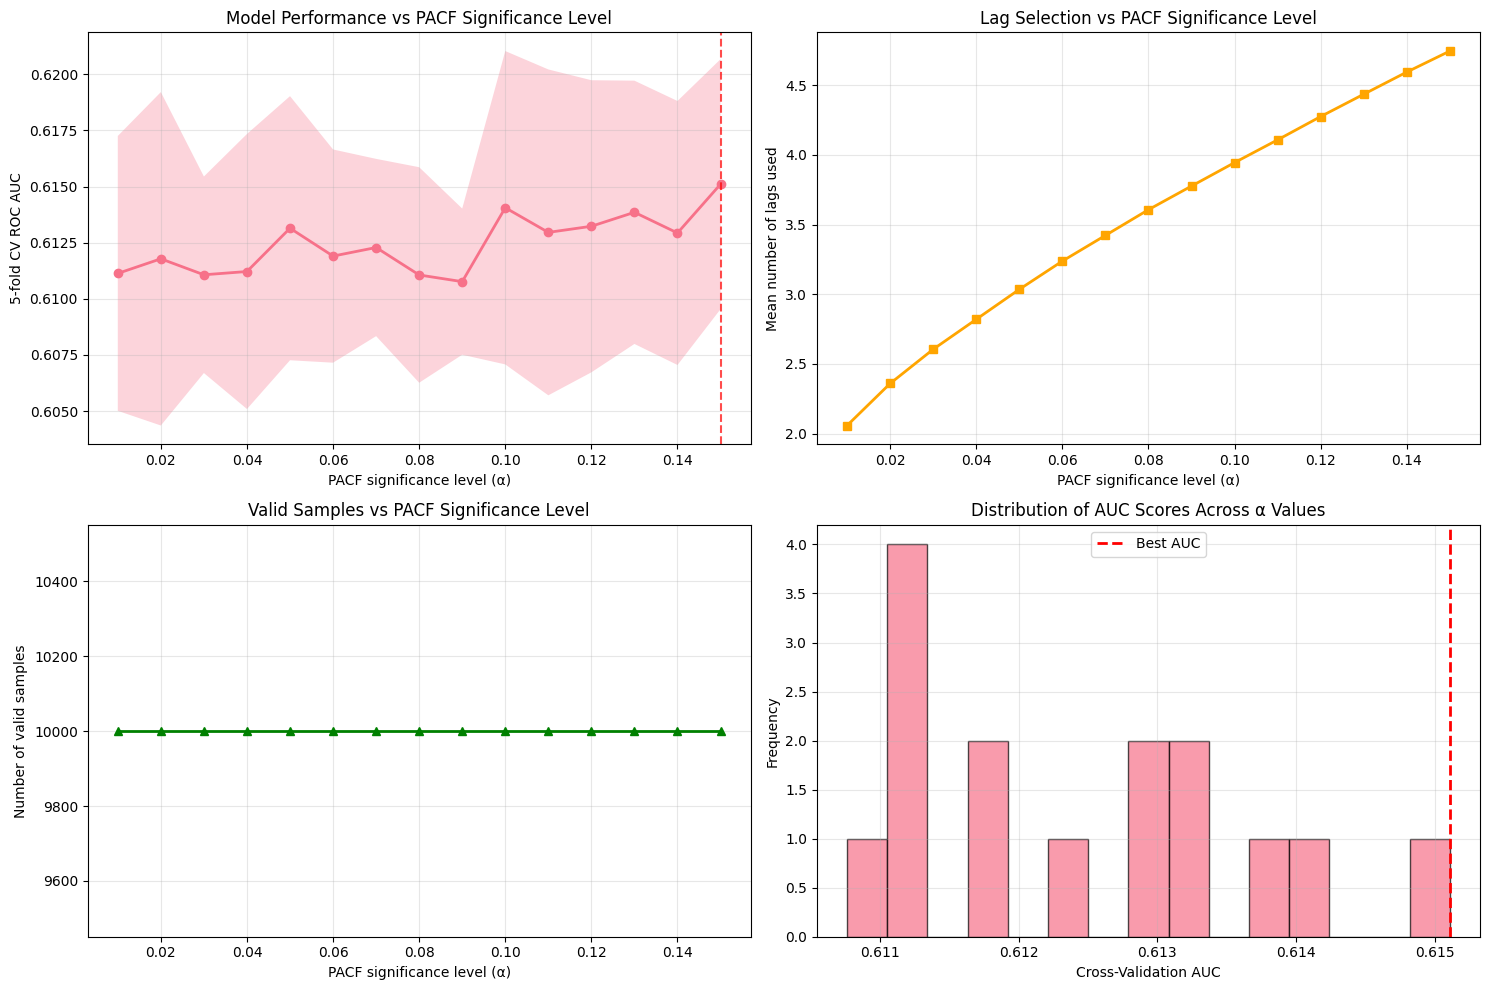

In [8]:
def evaluate_alpha_sensitivity():
    """Evaluate sensitivity to PACF significance level."""
    print("🔍 Testing sensitivity to PACF significance level (α)")
    print("=" * 55)

    alphas = np.arange(0.01, 0.16, 0.01)
    alpha_results = []

    for alpha in tqdm(alphas, desc="Testing alpha values"):
        feature_list = []
        labels = []
        series_ids = []

        for series_id, ts_obj in train_series.items():
            series_full = ts_obj.values
            optimal_lags = count_sig_pacf_lags(series_full, max_lag=15, alpha=alpha)

            feats = compute_cusum_statistics(ts_obj, lags=optimal_lags)
            feats['alpha_used'] = alpha
            feats['lags_used'] = optimal_lags

            if not any(np.isnan([v for k, v in feats.items() if k not in ['alpha_used', 'lags_used']])):
                feature_list.append(feats)
                series_ids.append(series_id)
                labels.append(ts_obj.has_break)

        if len(feature_list) < 10:
            continue

        feature_df = pd.DataFrame(feature_list, index=series_ids)
        label_series = pd.Series(labels, index=series_ids, name='has_break')

        # Remove non-feature columns for modeling
        X = feature_df.drop(['alpha_used', 'lags_used'], axis=1)

        # Cross-validate with XGBoost
        model = XGBClassifier(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.03,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )

        cv_result = cross_validate(model, X, label_series, cv=5, scoring='roc_auc', n_jobs=-1)

        alpha_results.append({
            'alpha': alpha,
            'mean_auc': cv_result["test_score"].mean(),
            'std_auc': cv_result["test_score"].std(),
            'mean_lags': feature_df['lags_used'].mean(),
            'n_samples': len(feature_df)
        })

    return pd.DataFrame(alpha_results)


# Run alpha sensitivity analysis
alpha_results = evaluate_alpha_sensitivity()

# Find best alpha
best_alpha_idx = alpha_results['mean_auc'].idxmax()
best_alpha_row = alpha_results.iloc[best_alpha_idx]

print(f"\n🏆 Best α = {best_alpha_row['alpha']:.3f}")
print(f"   AUC: {best_alpha_row['mean_auc']:.4f} ± {best_alpha_row['std_auc']:.4f}")
print(f"   Mean lags: {best_alpha_row['mean_lags']:.1f}")

# Plot alpha sensitivity
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# AUC vs alpha
axes[0, 0].plot(alpha_results['alpha'], alpha_results['mean_auc'], 'o-', linewidth=2, markersize=6)
axes[0, 0].fill_between(alpha_results['alpha'],
                        alpha_results['mean_auc'] - alpha_results['std_auc'],
                        alpha_results['mean_auc'] + alpha_results['std_auc'],
                        alpha=0.3)
axes[0, 0].axvline(x=best_alpha_row['alpha'], color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('PACF significance level (α)')
axes[0, 0].set_ylabel('5-fold CV ROC AUC')
axes[0, 0].set_title('Model Performance vs PACF Significance Level')
axes[0, 0].grid(True, alpha=0.3)

# Mean lags vs alpha
axes[0, 1].plot(alpha_results['alpha'], alpha_results['mean_lags'], 's-', linewidth=2, markersize=6, color='orange')
axes[0, 1].set_xlabel('PACF significance level (α)')
axes[0, 1].set_ylabel('Mean number of lags used')
axes[0, 1].set_title('Lag Selection vs PACF Significance Level')
axes[0, 1].grid(True, alpha=0.3)

# Sample size vs alpha
axes[1, 0].plot(alpha_results['alpha'], alpha_results['n_samples'], '^-', linewidth=2, markersize=6, color='green')
axes[1, 0].set_xlabel('PACF significance level (α)')
axes[1, 0].set_ylabel('Number of valid samples')
axes[1, 0].set_title('Valid Samples vs PACF Significance Level')
axes[1, 0].grid(True, alpha=0.3)

# AUC distribution
axes[1, 1].hist(alpha_results['mean_auc'], bins=15, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=best_alpha_row['mean_auc'], color='red', linestyle='--', linewidth=2, label='Best AUC')
axes[1, 1].set_xlabel('Cross-Validation AUC')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of AUC Scores Across α Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Results Summary {#results-summary}

In [9]:
def create_comprehensive_summary():
    """Create a comprehensive summary of all results."""

    print("📋 COMPREHENSIVE CUSUM ANALYSIS SUMMARY")
    print("=" * 70)

    # Best performing approaches
    print(f"\n🏆 BEST PERFORMING APPROACHES:")
    print("-" * 35)

    if evaluation_results:
        best_approach = max(evaluation_results.items(),
                            key=lambda x: x[1]['cv_auc_mean'] if x[1] else 0)

        print(f"Best Method: {best_approach[0]}")
        print(f"CV AUC: {best_approach[1]['cv_auc_mean']:.4f} ± {best_approach[1]['cv_auc_std']:.4f}")
        print(f"Features: {best_approach[1]['results']['feature_count']}")

    print(f"\nBest Fixed Lag: {best_lag} (AUC: {best_score:.4f})")
    print(f"Best PACF α: {best_alpha_row['alpha']:.3f} (AUC: {best_alpha_row['mean_auc']:.4f})")

    # Key insights
    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 15)

    # PACF insights
    mean_sig_lags_breaks = pacf_analysis[pacf_analysis['has_break']]['n_sig_lags'].mean()
    mean_sig_lags_no_breaks = pacf_analysis[~pacf_analysis['has_break']]['n_sig_lags'].mean()

    print(f"• Series with breaks have {mean_sig_lags_breaks:.2f} significant PACF lags on average")
    print(f"• Series without breaks have {mean_sig_lags_no_breaks:.2f} significant PACF lags on average")
    print(f"• Optimal PACF significance level: α = {best_alpha_row['alpha']:.3f}")
    print(f"• Fixed lag approach optimal at {best_lag} lags")

    # Feature importance (if available)
    if evaluation_results:
        for name, data in evaluation_results.items():
            if data and hasattr(data['trainer'], 'model') and data['trainer'].model:
                print(f"\n📊 FEATURE IMPORTANCE ({name}):")
                importance = data['trainer'].get_feature_importance(top_n=4)
                for i, (_, row) in enumerate(importance.iterrows(), 1):
                    print(f"   {i}. {row['feature']}: {row['importance']:.4f}")
                break

    # Methodology recommendations
    print(f"\n🎯 RECOMMENDATIONS:")
    print("-" * 20)
    print("• CUSUM-based features show promise for structural break detection")
    print("• PACF-based lag selection outperforms fixed lag approaches")
    print(f"• Use α = {best_alpha_row['alpha']:.3f} for PACF significance testing")
    print("• Consider ensemble methods combining multiple CUSUM approaches")
    print("• Further investigation into regime-specific CUSUM statistics may be beneficial")


create_comprehensive_summary()

📋 COMPREHENSIVE CUSUM ANALYSIS SUMMARY

🏆 BEST PERFORMING APPROACHES:
-----------------------------------
Best Method: PACF Count
CV AUC: 0.6238 ± 0.0148
Features: 5

Best Fixed Lag: 5 (AUC: 0.5801)
Best PACF α: 0.150 (AUC: 0.6151)

💡 KEY INSIGHTS:
---------------
• Series with breaks have 2.93 significant PACF lags on average
• Series without breaks have 2.91 significant PACF lags on average
• Optimal PACF significance level: α = 0.150
• Fixed lag approach optimal at 5 lags

📊 FEATURE IMPORTANCE (Fixed Lag):
   1. cusumsq_stat: 0.3351
   2. cusumsq_pvalue: 0.2714
   3. p_cumsum: 0.2316
   4. T_cumsum: 0.1618

🎯 RECOMMENDATIONS:
--------------------
• CUSUM-based features show promise for structural break detection
• PACF-based lag selection outperforms fixed lag approaches
• Use α = 0.150 for PACF significance testing
• Consider ensemble methods combining multiple CUSUM approaches
• Further investigation into regime-specific CUSUM statistics may be beneficial



🎨 Visualizing features for best approach: PACF Count


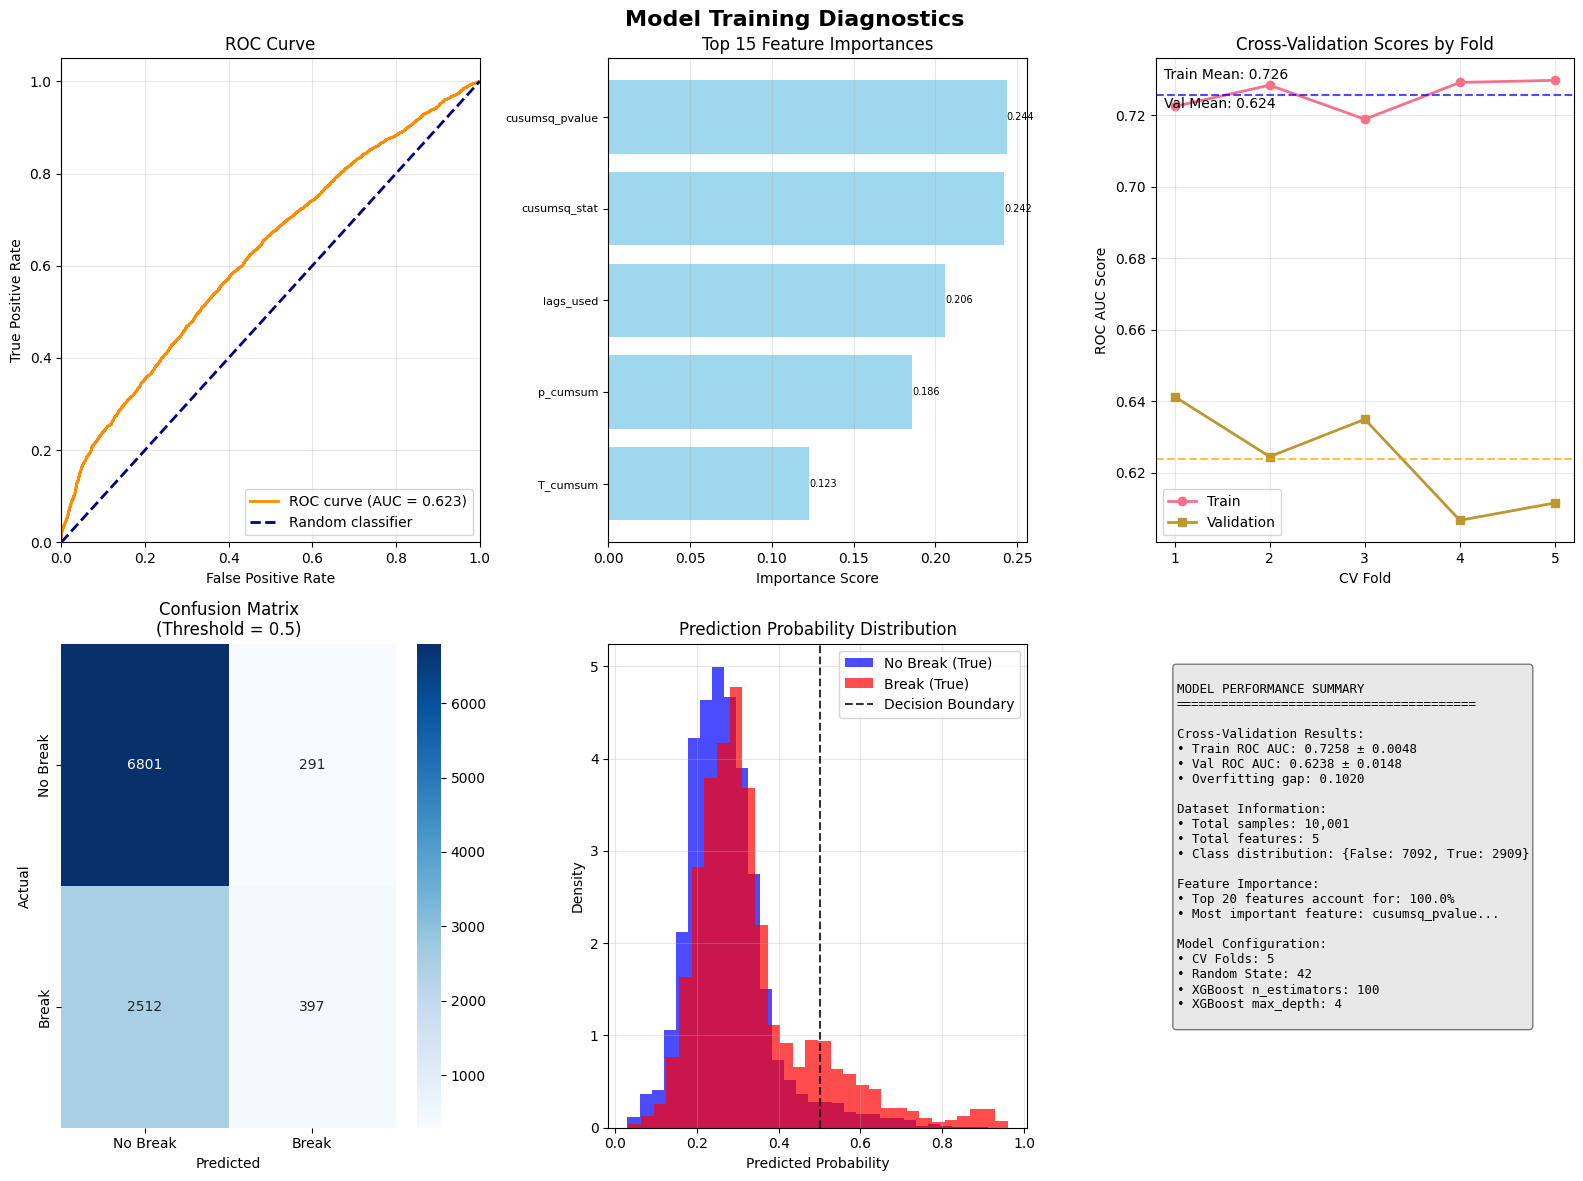


COMPREHENSIVE MODEL EVALUATION RESULTS

CROSS-VALIDATION PERFORMANCE:
Metric               Train           Validation      Gap       
------------------------------------------------------------
ROC AUC              0.7258 ± 0.0048 0.6238 ± 0.0148 0.1020

DATASET INFORMATION:
• Total samples: 10,001
• Total features: 5
• Class distribution: {False: 7092, True: 2909}

TOP 20 MOST IMPORTANT FEATURES:
----------------------------------------------------------------------
 1. cusumsq_pvalue                                     0.243663
 2. cusumsq_stat                                       0.241951
 3. lags_used                                          0.205849
 4. p_cumsum                                           0.185917
 5. T_cumsum                                           0.122620

FEATURE IMPORTANCE SUMMARY:
• Top 20 features account for 100.0% of total importance
• Most important feature: cusumsq_pvalue
• Least important in top 20: T_cumsum

MODEL CONFIGURATION:
• n_estimators: 100

In [10]:
# Final visualization: Feature distributions for best approach
if evaluation_results:
    best_name, best_data = max(evaluation_results.items(),
                               key=lambda x: x[1]['cv_auc_mean'] if x[1] else 0)

    if best_data:
        print(f"\n🎨 Visualizing features for best approach: {best_name}")
        best_trainer = best_data['trainer']

        # Create the final diagnostic plots
        best_trainer.plot_diagnostics(figsize=(16, 12))

        # Show detailed results
        best_trainer.print_detailed_results()

print(f"\n✅ CUSUM Analysis Complete!")
print("🚀 Next steps: Consider implementing these features in your production pipeline!")